# Importing Libraries

In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

In [2]:
df = pd.read_csv("train_product_data.csv")
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
2,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
3,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals",Footwear,SHOEH3DZBFR88SCK,699.0,349.0,"[""http://img6a.flixcart.com/image/shoe/b/p/n/p...",False,"Key Features of dilli bazaaar Bellies, Corpora...",No rating available,No rating available,dilli bazaaar,"{""product_specification""=>[{""key""=>""Occasion"",..."


# Data cleaning

In [3]:
df.isnull().sum()

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64

In [4]:
df = df[['description','product_category_tree']]
df.head()

,description,product_category_tree
0,Key Features of Alisha Solid Women's Cycling S...,Clothing
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear
2,Key Features of Alisha Solid Women's Cycling S...,Clothing
3,Key Features of Alisha Solid Women's Cycling S...,Clothing
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear


In [5]:
df.isnull().sum()

description              1
product_category_tree    0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
(df.duplicated().sum()/len(df))*100

12.214961994932658

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
df.shape

(13166, 2)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13166 entries, 0 to 14998
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   description            13166 non-null  object
 1   product_category_tree  13166 non-null  object
dtypes: object(2)
memory usage: 308.6+ KB


In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nelso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [13]:
def clean_text(text):
    if not isinstance(text, str):
        text = ""
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize text
    words = text.split()
    # Remove stopwords and lemmatize
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    # Join words back into a single string
    return ' '.join(words)

In [14]:
df['cleaned_description'] = df['description'].apply(clean_text)

In [15]:
df[['description', 'cleaned_description']].head(20)

,description,cleaned_description
0,Key Features of Alisha Solid Women's Cycling S...,key feature alisha solid womens cycling short ...
1,Key Features of AW Bellies Sandals Wedges Heel...,key feature aw belly sandal wedge heel casuals...
2,Key Features of Alisha Solid Women's Cycling S...,key feature alisha solid womens cycling short ...
3,Key Features of Alisha Solid Women's Cycling S...,key feature alisha solid womens cycling short ...
4,"Key Features of dilli bazaaar Bellies, Corpora...",key feature dilli bazaaar belly corporate casu...
5,Key Features of Alisha Solid Women's Cycling S...,key feature alisha solid womens cycling short ...
6,Key Features of Ladela Bellies Brand: LADELA C...,key feature ladela belly brand ladela color bl...
7,Key Features of Carrel Printed Women's Fabric:...,key feature carrel printed womens fabric swiml...
8,Key Features of Alisha Solid Women's Cycling S...,key feature alisha solid womens cycling short ...
9,Specifications of Freelance Vacuum Bottles 350...,specification freelance vacuum bottle ml bottl...


# Encoding the data

In [16]:
sentences = [text.split() for text in df['cleaned_description']]
model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
word_vectors = model.wv

In [17]:
def get_embedding(text):
    words = text.split()
    word_embeddings = [word_vectors[word] for word in words if word in word_vectors]
    if word_embeddings:
        return np.mean(word_embeddings, axis=0)  # Average embedding of all words in the description
    else:
        return np.zeros(word_vectors.vector_size) 

In [18]:
df['embeddings'] = df['cleaned_description'].apply(get_embedding)

In [19]:
print(df[['description', 'embeddings']].head(20))

                                          description  \
0   Key Features of Alisha Solid Women's Cycling S...   
1   Key Features of AW Bellies Sandals Wedges Heel...   
2   Key Features of Alisha Solid Women's Cycling S...   
3   Key Features of Alisha Solid Women's Cycling S...   
4   Key Features of dilli bazaaar Bellies, Corpora...   
5   Key Features of Alisha Solid Women's Cycling S...   
6   Key Features of Ladela Bellies Brand: LADELA C...   
7   Key Features of Carrel Printed Women's Fabric:...   
8   Key Features of Alisha Solid Women's Cycling S...   
9   Specifications of Freelance Vacuum Bottles 350...   
10  Key Features of Alisha Solid Women's Cycling S...   
11  Key Features of Style Foot Bellies ballerina s...   
12  Key Features of Carrel Printed Women's Fabric:...   
13  Alisha Solid Women's Cycling Shorts - Buy Blac...   
14  Specifications of dongli Printed Boy's Round N...   
15  Key Features of SWAGGA Women Clogs Occasion: E...   
16  Glus Wedding Lingerie Set -

In [20]:
df['product_category_tree'].value_counts()

product_category_tree
Clothing                       4663
Jewellery                      2658
Footwear                        988
Automotive                      935
Home Decor & Festive Needs      606
Kitchen & Dining                606
Computers                       529
Watches                         526
Mobiles & Accessories           501
Tools & Hardware                321
Toys & School Supplies          262
Pens & Stationery               224
Baby Care                       195
Bags, Wallets & Belts           152
Name: count, dtype: int64

# Exploratory data analysis

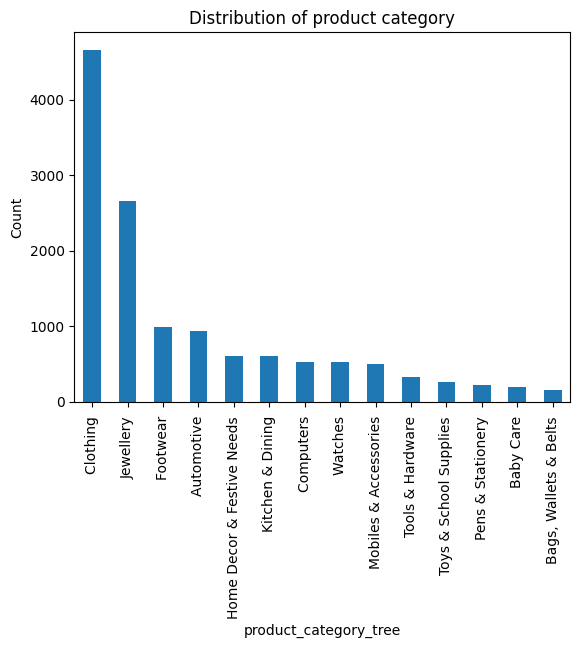

In [21]:
categories = df['product_category_tree'].value_counts()
categories.plot(kind='bar')
plt.ylabel("Count")
plt.title("Distribution of product category")
plt.show()

In [22]:
label_encoder = LabelEncoder()
df['encoded_products'] = label_encoder.fit_transform(df['product_category_tree'])
print(df[['product_category_tree', 'encoded_products']].head(10))

  product_category_tree  encoded_products
0             Clothing                  3
1             Footwear                  5
2             Clothing                  3
3             Clothing                  3
4             Footwear                  5
5             Clothing                  3
6             Footwear                  5
7             Clothing                  3
8             Clothing                  3
9    Pens & Stationery                 10


In [23]:
df.head()

,description,product_category_tree,cleaned_description,embeddings,encoded_products
0,Key Features of Alisha Solid Women's Cycling S...,Clothing,key feature alisha solid womens cycling short ...,"[1.2882044, -0.47756082, 0.18383597, -0.285330...",3
1,Key Features of AW Bellies Sandals Wedges Heel...,Footwear,key feature aw belly sandal wedge heel casuals...,"[0.84305125, 0.019422807, -0.059295375, -0.324...",5
2,Key Features of Alisha Solid Women's Cycling S...,Clothing,key feature alisha solid womens cycling short ...,"[1.2880303, -0.48601848, 0.18329328, -0.278882...",3
3,Key Features of Alisha Solid Women's Cycling S...,Clothing,key feature alisha solid womens cycling short ...,"[1.2748681, -0.43460953, 0.16705456, -0.286732...",3
4,"Key Features of dilli bazaaar Bellies, Corpora...",Footwear,key feature dilli bazaaar belly corporate casu...,"[0.9735362, -0.06125712, -0.15856062, -0.14339...",5


# Spliting the data

In [24]:
X = np.array(df['embeddings'].to_list())
y = df['encoded_products']

In [25]:
smote = SMOTE(sampling_strategy='auto', random_state=42)

In [26]:
X_res, y_res = smote.fit_resample(X, y)

In [27]:
y_res.value_counts()

encoded_products
3     4663
5     4663
10    4663
2     4663
6     4663
0     4663
11    4663
1     4663
9     4663
13    4663
12    4663
7     4663
8     4663
4     4663
Name: count, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Random Forest

In [30]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [31]:
print("Accuracy:",f1_score(y_test, y_pred_rf, average='weighted'))
print("Classification Report:\n",classification_report(y_test,y_pred_rf))
print("Confusion Matrix:\n",confusion_matrix(y_test,y_pred_rf))

Accuracy: 0.9966281821802117
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.99      1.00      0.99       924
           2       1.00      1.00      1.00       917
           3       1.00      0.98      0.99       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       1.00      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      1.00      1.00       904
          10       0.98      0.99      0.99       889
          11       1.00      1.00      1.00       965
          12       1.00      0.98      0.99       947
          13       1.00      1.00      1.00       936

    accuracy                           1.00     13057
   macro avg       1.00      1.00      1.00     13057
weighted avg       1.00    

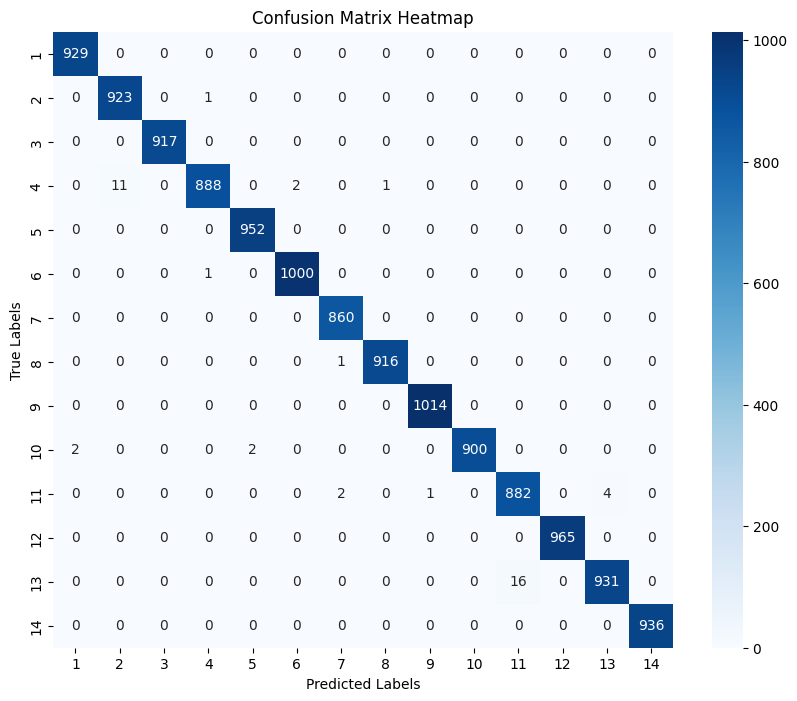

In [32]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for random forest

In [33]:
param_grid = {
    'n_estimators': [100],
    'max_depth': [10, None],
    'min_samples_split': [2],
}

In [34]:
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2, scoring='f1_weighted')

In [35]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, None], 'min_samples_split': [2],
                         'n_estimators': [100]},
             scoring='f1_weighted', verbose=2)

In [36]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best F1 Score: 0.9953664115479551


In [37]:
best_rf_model = grid_search.best_estimator_
y_pred_best_rf = best_rf_model.predict(X_test)

In [38]:
print("F1 Score:", f1_score(y_test, y_pred_best_rf, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_best_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best_rf))

F1 Score: 0.9966281821802117
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.99      1.00      0.99       924
           2       1.00      1.00      1.00       917
           3       1.00      0.98      0.99       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       1.00      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      1.00      1.00       904
          10       0.98      0.99      0.99       889
          11       1.00      1.00      1.00       965
          12       1.00      0.98      0.99       947
          13       1.00      1.00      1.00       936

    accuracy                           1.00     13057
   macro avg       1.00      1.00      1.00     13057
weighted avg       1.00    

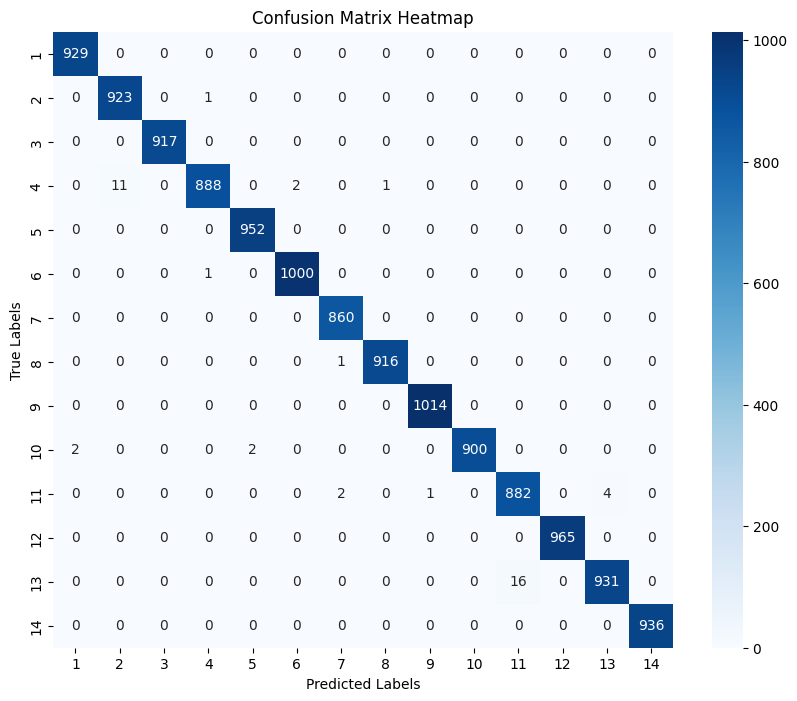

In [39]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_best_rf)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Logistic Regression

In [40]:
lr_model = LogisticRegression(max_iter=500,random_state=42)
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

In [41]:
print("F1 score:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

F1 score: 0.9422963136075069
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       929
           1       0.95      0.93      0.94       924
           2       0.95      0.98      0.96       917
           3       0.98      0.96      0.97       902
           4       0.95      0.96      0.95       952
           5       1.00      0.99      0.99      1001
           6       0.93      0.96      0.94       860
           7       0.99      0.99      0.99       917
           8       0.96      0.94      0.95      1014
           9       0.96      0.96      0.96       904
          10       0.83      0.68      0.75       889
          11       0.97      0.95      0.96       965
          12       0.77      0.92      0.84       947
          13       1.00      1.00      1.00       936

    accuracy                           0.94     13057
   macro avg       0.94      0.94      0.94     13057
weighted avg       0.94    

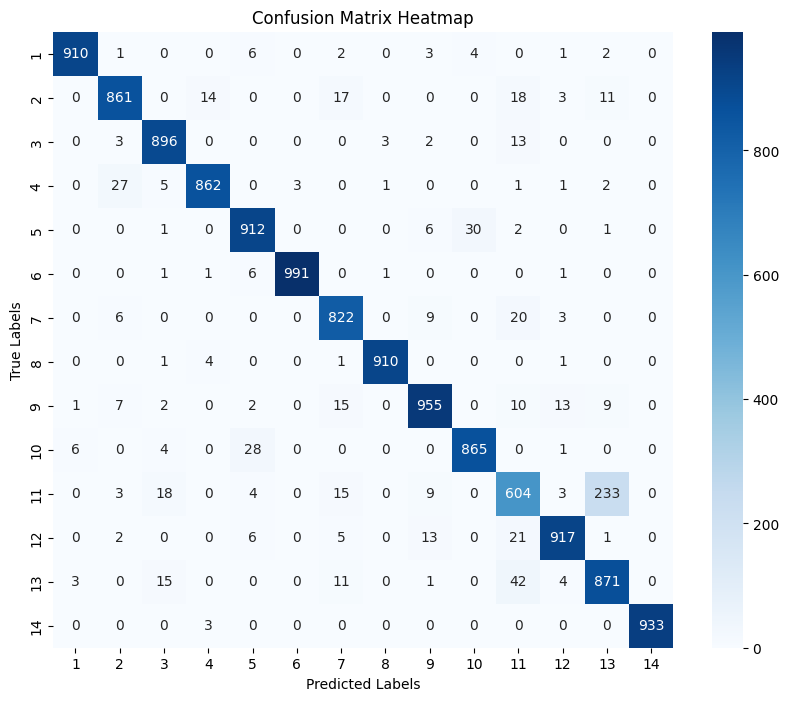

In [42]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_lr)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for Logistic regression

In [43]:
param_grid = {
    'C': [10],  
    'penalty': ['l2'], 
    'solver': ['liblinear'], 
    'multi_class': ['ovr'] 
}

In [44]:
grid_search = GridSearchCV(
    estimator=lr_model,
    param_grid=param_grid,
    scoring='f1_weighted',  # You can use accuracy, recall, etc.
    cv=3,  # Number of folds for cross-validation
    verbose=3,
    n_jobs=-1  # Use all processors
)

In [45]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'C': [10], 'multi_class': ['ovr'], 'penalty': ['l2'],
                         'solver': ['liblinear']},
             scoring='f1_weighted', verbose=3)

In [46]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Best Parameters: {'C': 10, 'multi_class': 'ovr', 'penalty': 'l2', 'solver': 'liblinear'}
Best F1-Score: 0.9470147122112472


In [47]:
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test)

In [48]:
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

F1 score: 0.9514020420944408
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       929
           1       0.95      0.95      0.95       924
           2       0.95      0.98      0.96       917
           3       0.99      0.96      0.97       902
           4       0.95      0.96      0.96       952
           5       1.00      0.99      0.99      1001
           6       0.93      0.97      0.95       860
           7       0.99      1.00      1.00       917
           8       0.96      0.97      0.96      1014
           9       0.97      0.96      0.96       904
          10       0.89      0.68      0.77       889
          11       0.99      0.95      0.97       965
          12       0.79      0.94      0.86       947
          13       1.00      1.00      1.00       936

    accuracy                           0.95     13057
   macro avg       0.95      0.95      0.95     13057
weighted avg       0.95    

# K-Nearest Neighbors

In [49]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

In [50]:
print("F1 score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

F1 score: 0.9932396384113932
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.96      1.00      0.98       924
           2       1.00      1.00      1.00       917
           3       1.00      0.95      0.97       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       0.99      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      1.00      1.00       904
          10       1.00      0.97      0.98       889
          11       1.00      1.00      1.00       965
          12       0.98      1.00      0.99       947
          13       1.00      1.00      1.00       936

    accuracy                           0.99     13057
   macro avg       0.99      0.99      0.99     13057
weighted avg       0.99    

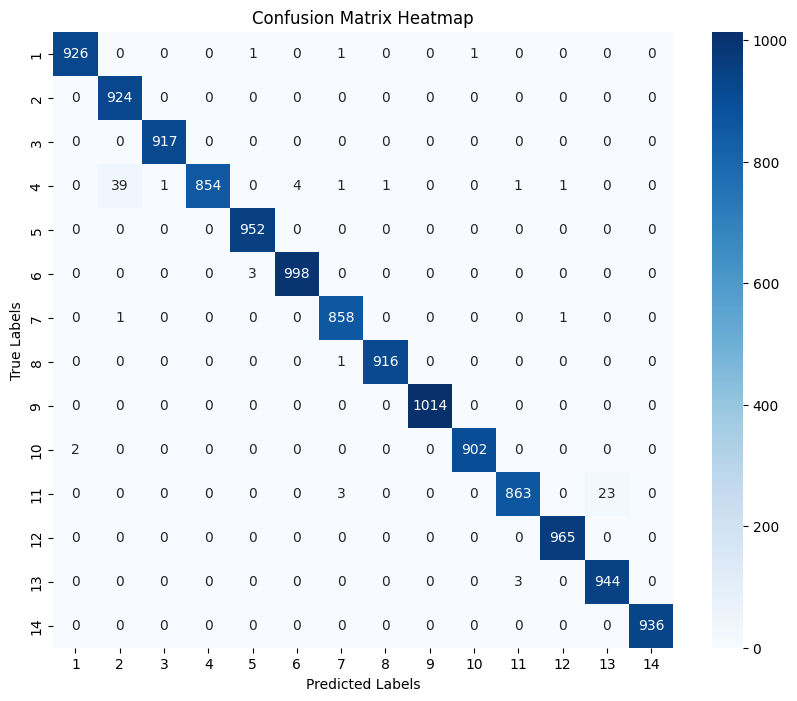

In [51]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for K-Nearest Neighbors

In [52]:
param_grid_knn = {
    'n_neighbors': [5],  # Number of neighbors
    'weights': ['distance'],  # Weight function
    'metric': ['minkowski']  # Distance metric
}

In [53]:
grid_search_knn = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid_knn,
    scoring='f1_weighted',
    cv=3,
    verbose=3,
    n_jobs=-1
)

In [54]:
grid_search_knn.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['minkowski'], 'n_neighbors': [5],
                         'weights': ['distance']},
             scoring='f1_weighted', verbose=3)

In [55]:
print("Best Parameters (KNN):", grid_search_knn.best_params_)
print("Best F1-Score (KNN):", grid_search_knn.best_score_)

Best Parameters (KNN): {'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'distance'}
Best F1-Score (KNN): 0.9919619038635528


In [56]:
best_knn_model = grid_search_knn.best_estimator_
y_pred_knn = best_knn_model.predict(X_test)

In [57]:
print("F1 score:", f1_score(y_test, y_pred_knn, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

F1 score: 0.9943181776153482
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.97      1.00      0.98       924
           2       1.00      1.00      1.00       917
           3       1.00      0.96      0.98       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       1.00      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      1.00      1.00       904
          10       1.00      0.97      0.98       889
          11       1.00      1.00      1.00       965
          12       0.98      1.00      0.99       947
          13       1.00      1.00      1.00       936

    accuracy                           0.99     13057
   macro avg       0.99      0.99      0.99     13057
weighted avg       0.99    

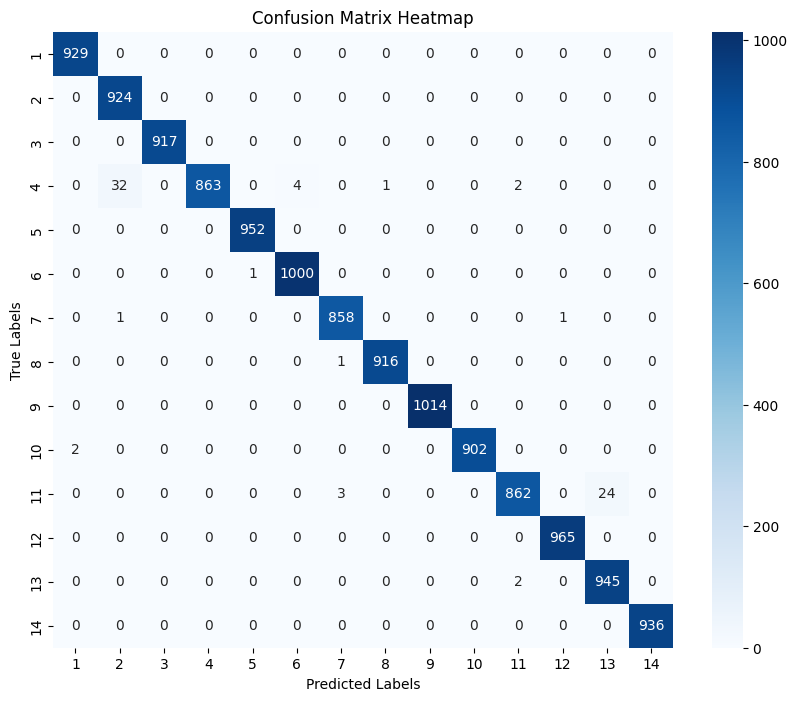

In [58]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Support Vector machines

In [59]:
svc_model = SVC(random_state=42)
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)

In [60]:
print("F1 score:", f1_score(y_test, y_pred_svc, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_svc))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_svc))

F1 score: 0.9491038642325009
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       929
           1       0.96      0.94      0.95       924
           2       0.97      0.98      0.98       917
           3       0.99      0.96      0.98       902
           4       0.96      0.96      0.96       952
           5       1.00      0.99      1.00      1001
           6       0.96      0.96      0.96       860
           7       1.00      0.99      1.00       917
           8       0.96      0.96      0.96      1014
           9       0.97      0.97      0.97       904
          10       0.81      0.67      0.73       889
          11       0.99      0.95      0.97       965
          12       0.76      0.95      0.84       947
          13       1.00      0.99      1.00       936

    accuracy                           0.95     13057
   macro avg       0.95      0.95      0.95     13057
weighted avg       0.95    

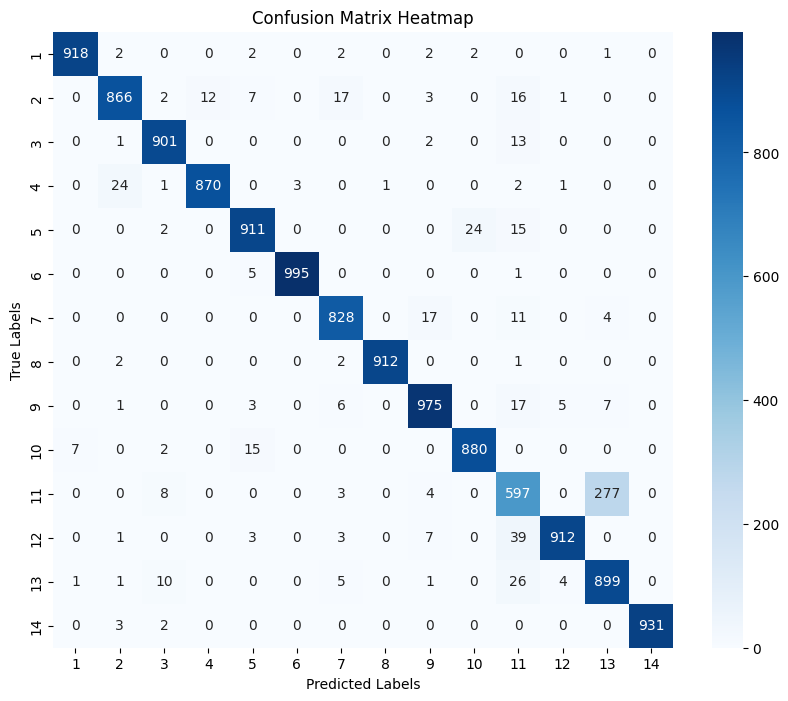

In [61]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_svc)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for Support vector machines

In [62]:
param_grid_svc = {
    'C': [1.0],           
    'kernel': ['rbf'],      
    'gamma': ['scale'],     
    'degree': [3],           
    'class_weight': [None]   
}

In [63]:
grid_search_svc = GridSearchCV(
    estimator=svc_model,
    param_grid=param_grid_svc,
    scoring='f1_weighted',
    cv=3,
    verbose=3,
    n_jobs=-1
)

In [64]:
grid_search_svc.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [1.0], 'class_weight': [None], 'degree': [3],
                         'gamma': ['scale'], 'kernel': ['rbf']},
             scoring='f1_weighted', verbose=3)

In [65]:
print("Best Parameters:", grid_search_svc.best_params_)
print("Best F1-Score:", grid_search_svc.best_score_)

Best Parameters: {'C': 1.0, 'class_weight': None, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best F1-Score: 0.93892226345249


In [66]:
best_svc_model = grid_search_svc.best_estimator_
y_pred = best_svc_model.predict(X_test)

In [67]:
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

F1 score: 0.9491038642325009
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99       929
           1       0.96      0.94      0.95       924
           2       0.97      0.98      0.98       917
           3       0.99      0.96      0.98       902
           4       0.96      0.96      0.96       952
           5       1.00      0.99      1.00      1001
           6       0.96      0.96      0.96       860
           7       1.00      0.99      1.00       917
           8       0.96      0.96      0.96      1014
           9       0.97      0.97      0.97       904
          10       0.81      0.67      0.73       889
          11       0.99      0.95      0.97       965
          12       0.76      0.95      0.84       947
          13       1.00      0.99      1.00       936

    accuracy                           0.95     13057
   macro avg       0.95      0.95      0.95     13057
weighted avg       0.95    

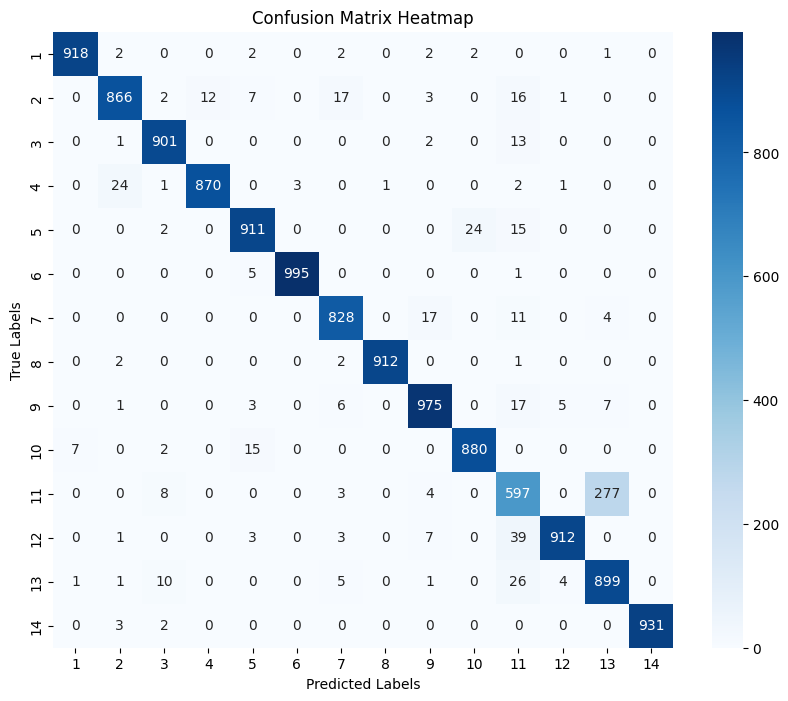

In [68]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# XGBoost

In [69]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

In [70]:
print("F1 score:", f1_score(y_test, y_pred_xgb, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

F1 score: 0.9969364061677105
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.99      1.00      0.99       924
           2       1.00      1.00      1.00       917
           3       1.00      0.98      0.99       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       1.00      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      1.00      1.00       904
          10       0.98      1.00      0.99       889
          11       1.00      1.00      1.00       965
          12       1.00      0.99      0.99       947
          13       1.00      1.00      1.00       936

    accuracy                           1.00     13057
   macro avg       1.00      1.00      1.00     13057
weighted avg       1.00    

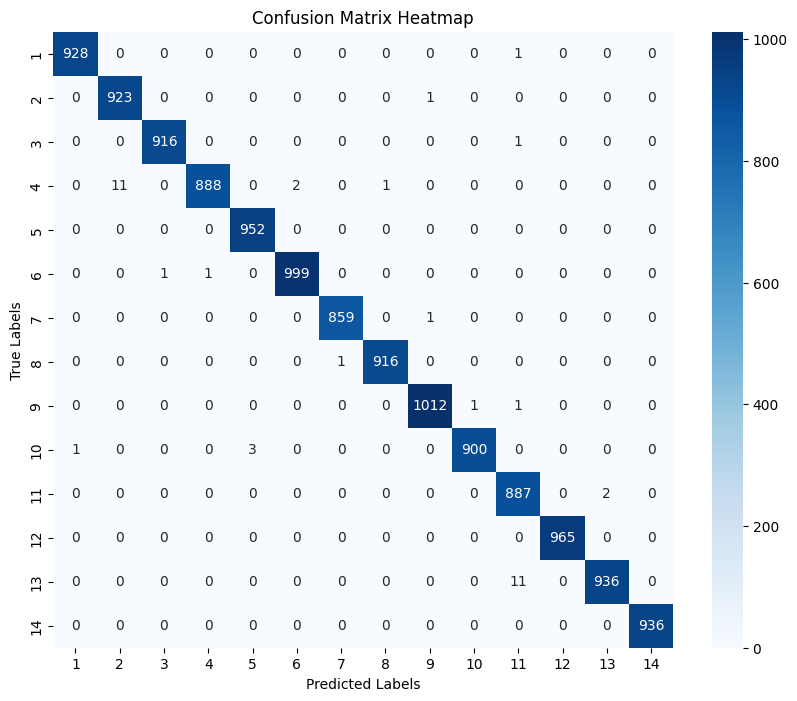

In [71]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for xgboost

In [72]:
param_grid = {
    'n_estimators': [200],  
    'learning_rate': [0.05],  
    'max_depth': [5], 
    'min_child_weight': [2],  
    'gamma': [0.1],  
}

In [73]:
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='f1_weighted', n_jobs=-1, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     objective='multi:softprob', ...),
             n_jobs=-1,
             param_grid={'gamma': [0.1], 'learning_rate': [0.05],
                         'max_depth': [5], 'min_child_weight': [2],
                         'n_estimators': [200]},
             scoring='f1_weighted', verbose=2)

In [74]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Best Parameters: {'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 5, 'min_child_weight': 2, 'n_estimators': 200}
Best F1-Score: 0.9893070105273601


In [75]:
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)

In [76]:
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

F1 score: 0.9928039753141076
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       929
           1       0.98      1.00      0.99       924
           2       1.00      1.00      1.00       917
           3       1.00      0.98      0.99       902
           4       1.00      1.00      1.00       952
           5       1.00      1.00      1.00      1001
           6       1.00      1.00      1.00       860
           7       1.00      1.00      1.00       917
           8       1.00      1.00      1.00      1014
           9       1.00      0.99      1.00       904
          10       0.96      0.98      0.97       889
          11       1.00      1.00      1.00       965
          12       0.98      0.97      0.97       947
          13       1.00      1.00      1.00       936

    accuracy                           0.99     13057
   macro avg       0.99      0.99      0.99     13057
weighted avg       0.99    

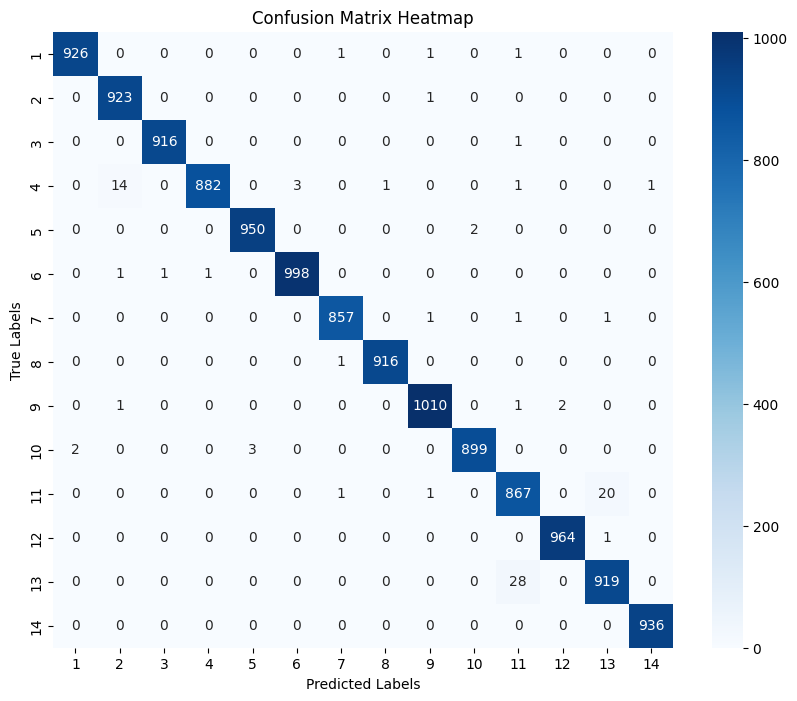

In [77]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Naive Bayes

In [78]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

In [79]:
print("F1 score:", f1_score(y_test, y_pred_nb, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

F1 score: 0.6866146458699116
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       929
           1       0.48      0.66      0.56       924
           2       0.71      0.47      0.56       917
           3       0.89      0.74      0.81       902
           4       0.57      0.76      0.65       952
           5       0.92      0.68      0.78      1001
           6       0.68      0.89      0.77       860
           7       1.00      0.91      0.95       917
           8       0.78      0.53      0.63      1014
           9       0.39      0.74      0.51       904
          10       0.33      0.19      0.24       889
          11       0.97      0.70      0.82       965
          12       0.47      0.67      0.55       947
          13       1.00      0.86      0.93       936

    accuracy                           0.68     13057
   macro avg       0.73      0.68      0.69     13057
weighted avg       0.73    

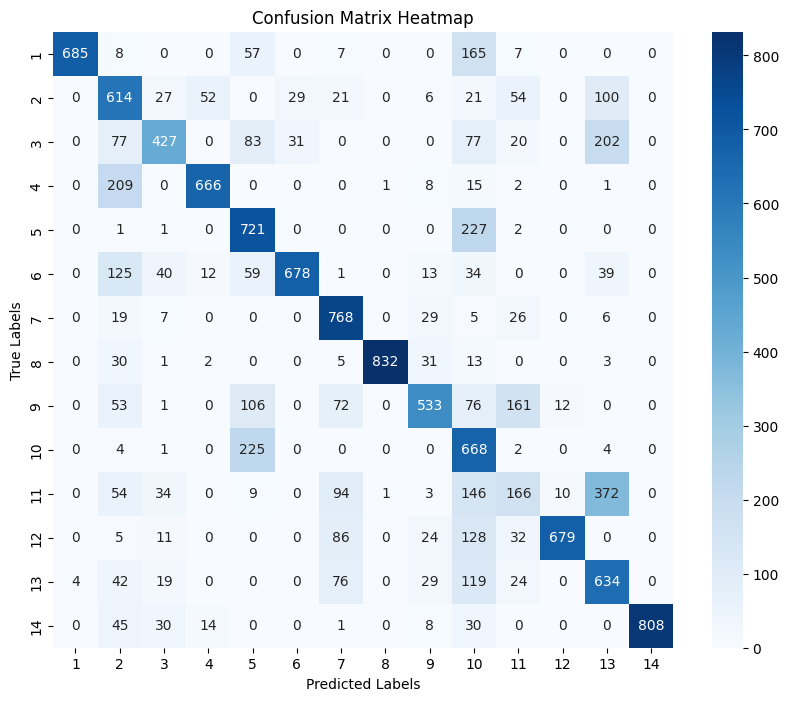

In [80]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred_nb)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Hyper paramter tuning for Naive Bayes

In [81]:
param_grid = {
    'var_smoothing': [1e-10]
}

In [82]:
grid_search = GridSearchCV(estimator=nb_model, param_grid=param_grid, scoring='f1_weighted', n_jobs=-1, cv=3, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-10]}, scoring='f1_weighted',
             verbose=2)

In [83]:
print("Best Parameters:", grid_search.best_params_)
print("Best F1-Score:", grid_search.best_score_)

Best Parameters: {'var_smoothing': 1e-10}
Best F1-Score: 0.6900518752199448


In [84]:
best_nb_model = grid_search.best_estimator_
y_pred = best_nb_model.predict(X_test)

In [85]:
print("F1 score:", f1_score(y_test, y_pred, average='weighted'))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

F1 score: 0.6866146458699116
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.74      0.85       929
           1       0.48      0.66      0.56       924
           2       0.71      0.47      0.56       917
           3       0.89      0.74      0.81       902
           4       0.57      0.76      0.65       952
           5       0.92      0.68      0.78      1001
           6       0.68      0.89      0.77       860
           7       1.00      0.91      0.95       917
           8       0.78      0.53      0.63      1014
           9       0.39      0.74      0.51       904
          10       0.33      0.19      0.24       889
          11       0.97      0.70      0.82       965
          12       0.47      0.67      0.55       947
          13       1.00      0.86      0.93       936

    accuracy                           0.68     13057
   macro avg       0.73      0.68      0.69     13057
weighted avg       0.73    

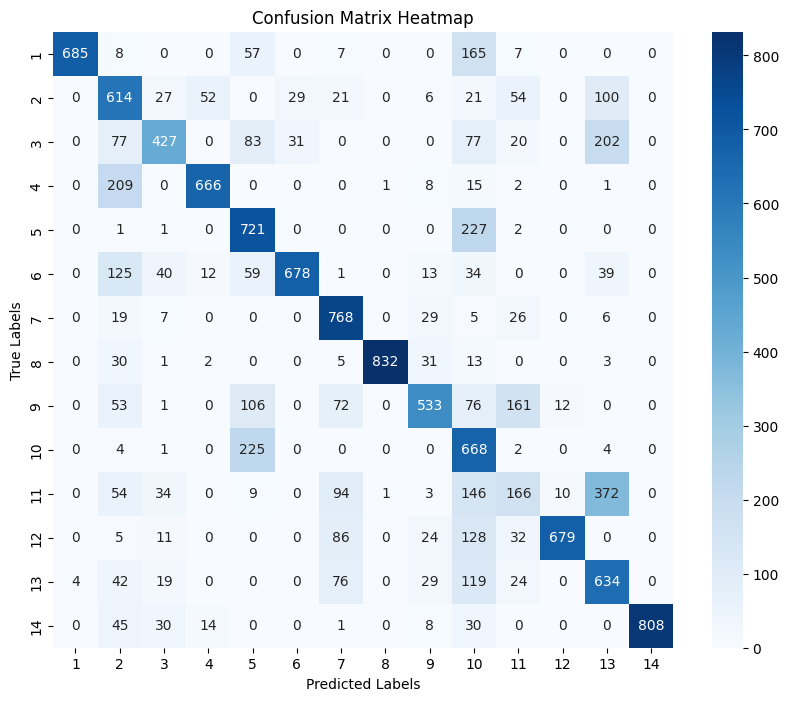

In [86]:
plt.figure(figsize=(10, 8))
conf_matrix = confusion_matrix(y_test,y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(1, 15), yticklabels=np.arange(1, 15))

plt.title("Confusion Matrix Heatmap")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Testing the data with real word data

In [119]:
df = pd.read_csv('test_data.csv')

In [120]:
df['cleaned_description'] = df['description'].apply(clean_text)
df['embeddings'] = df['cleaned_description'].apply(get_embedding)

In [121]:
data = np.array(df['embeddings'].to_list())

In [122]:
predict = best_knn_model.predict(data)

In [123]:
predict

array([12,  7,  9, ...,  1,  1,  1])